In [1]:

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
from numpy.random import rand, randn
import pyprobml_utils as pml


def plot_gmm_3d_trace(trace_hist, π, μ, σ, title, xmin, xmax, ax, n_iterations, h=1, n_eval=500):
    x_eval = np.linspace(xmin, xmax, n_eval)
    kde_eval = pml.kdeg(x_eval[:, None], trace_hist[:, None], h)
    px = norm(μ, σ).pdf(x_eval[:, None]) * π
    px = px.sum(axis=-1)

    ax.plot(np.arange(n_iterations), trace_hist)
    ax.plot(np.zeros(n_eval), x_eval, px, c="tab:red", linewidth=2)
    ax.plot(np.zeros(n_eval), x_eval, kde_eval, c="tab:blue")

    ax.set_zlim(0, kde_eval.max() * 1.1)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Samples")

    ax.view_init(25, -30)
    ax.set_title(title)


def gibbs_sample(xs, zs, kv, π, μ, σ, n_iterations):
    x_hist = np.zeros(n_iterations)
    z_hist = np.zeros(n_iterations)
    x_hist[0] = xs
    z_hist[0] = zs

    for s in range(1, n_iterations):
        pz = norm(μ, σ).pdf(xs) * π
        pz = pz / pz.sum()
        zs = np.random.choice(kv, p=pz)
        xs = norm(μ[zs], σ[zs]).rvs()
        x_hist[s] = xs
        z_hist[s] = zs
    
    return x_hist, z_hist


def metropolis_sample(xs, τ, π, μ, σ, n_iterations):
    hist = np.zeros(n_iterations)
    hist[0] = xs

    for s in range(1, n_iterations):
        x_candidate = xs + τ * randn()
        p_candidate = (norm(μ, σ).pdf(x_candidate) * π).sum()
        p_curr = (norm(μ, σ).pdf(xs) * π).sum()
        α = p_candidate / p_curr
        A = min(1, α)
        u = rand()
        xs = xs if u >= A else x_candidate
        hist[s] = xs
        
    return hist


def sample_plot_gibbs(x0, z0, kv, π, μ, σ, n_iterations, xmin, xmax):
    x_hist, z_hist = gibbs_sample(x0, z0, kv, π, μ, σ, n_iterations)
    colors = ["tab:blue" if z else "tab:red" for z in z_hist]

    fig, axs = plt.subplots()
    axs.scatter(np.arange(n_iterations), x_hist, s=20, facecolors="none", edgecolors=colors)
    pml.savefig("gibbs_scatter.pdf")

    fig = plt.figure()
    axs = plt.axes(projection="3d")
    plot_gmm_3d_trace(x_hist, π, μ, σ, "Gibbs sampling", xmin, xmax, axs, n_iterations)
    pml.style3d(axs, 1.5, 1, 0.8)
    plt.subplots_adjust(left=0.001, bottom=0.208, right=0.7)
    pml.savefig("gibbs_trace.pdf", pad_inches=0, bbox_inches="tight")

    fig, axs = plt.subplots()
    sm.graphics.tsa.plot_acf(x_hist, lags=45, alpha=None, title="Gibbs", ax=axs)
    pml.savefig("gibbs_autocorrelation.pdf")


def sample_plot_mh(x0, τ, π, μ, σ, n_iterations, xmin, xmax):
    x_hist = metropolis_sample(x0, τ, π, μ, σ, n_iterations)

    fig = plt.figure()
    axs = plt.axes(projection="3d")
    plot_gmm_3d_trace(x_hist, π, μ, σ, f"MH with $N(0,{τ}^2)$ proposal", xmin, xmax, axs, n_iterations)
    pml.style3d(axs, 1.5, 1, 0.8)
    plt.subplots_adjust(left=0.001, bottom=0.208)
    pml.savefig(f"mh_trace_{τ}tau.pdf", pad_inches=0, bbox_inches="tight")

    fig, axs = plt.subplots()
    sm.graphics.tsa.plot_acf(x_hist, lags=45, alpha=None, title=f"MH with $N(0,{τ}^2)$ proposal", ax=axs)
    pml.savefig(f"mh_autocorrelation_{τ}tau.pdf")



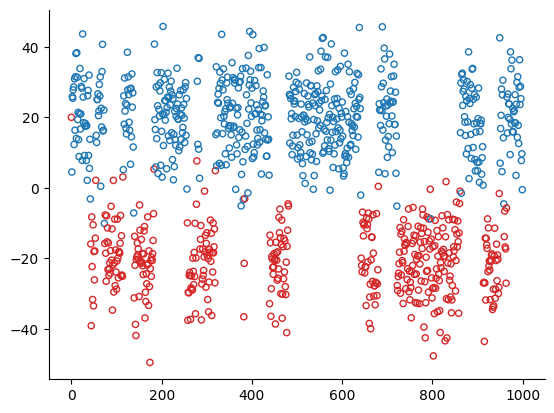

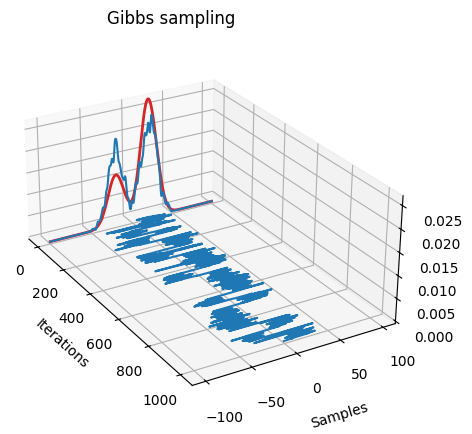

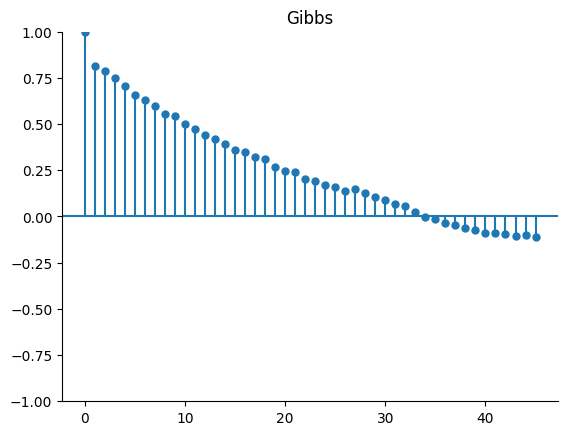

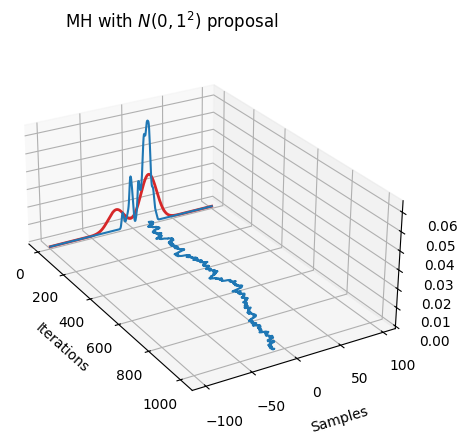

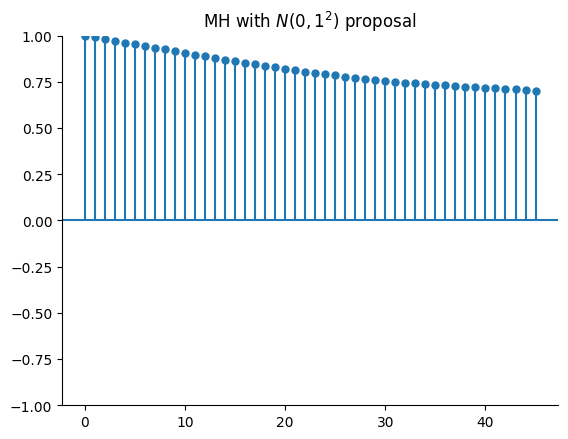

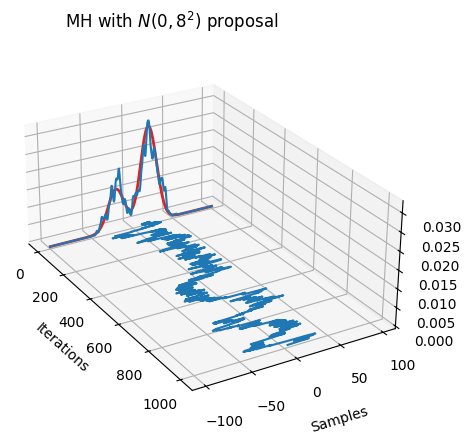

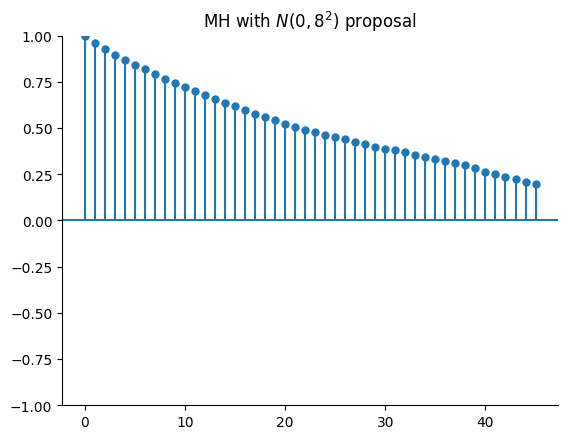

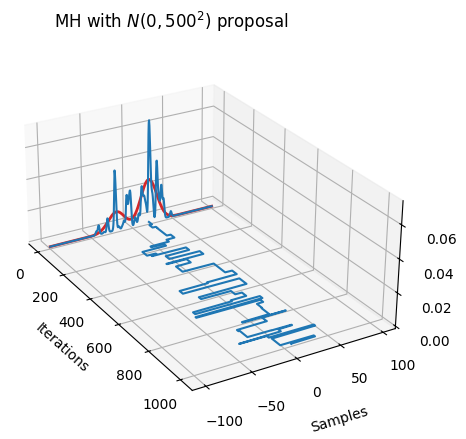

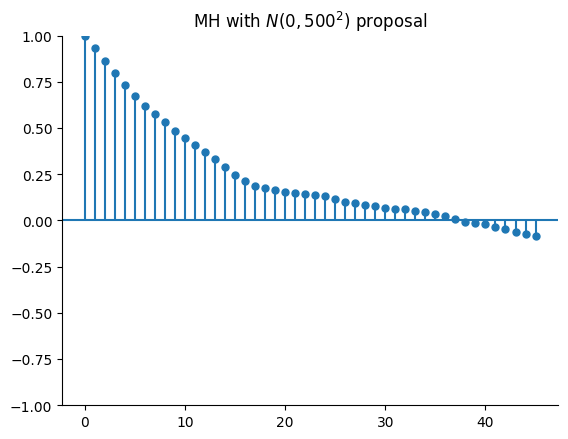

In [2]:

if __name__ == "__main__":
    plt.rcParams["axes.spines.right"] = False
    plt.rcParams["axes.spines.top"] = False

    xmin, xmax = -100, 100
    x0, z0 = 20, 0
    τ_values = [1, 8, 500]
    n_iterations = 1000
    μ = np.array([-20, 20.])
    σ = np.array([10, 10.])
    π = np.array([0.3, 0.7])
    kv = np.arange(2)

    np.random.seed(314)
    sample_plot_gibbs(x0, z0, kv, π, μ, σ, n_iterations, xmin, xmax)
    for τ in τ_values:
        sample_plot_mh(x0, τ, π, μ, σ, n_iterations, xmin, xmax)
    plt.show()
